type(apod) = <class 'bool'>


C:\Users\user\AppData\Local\Temp\ipykernel_8764\2158896603.py:200: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  result = (-1) ** s * np.math.factorial(int(n - s)) * r ** (n - 2 * s) / (
C:\Users\user\AppData\Local\Temp\ipykernel_8764\2158896603.py:201: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  np.math.factorial(int(s)) * np.math.factorial(int((n + m) // 2 - s)) *
C:\Users\user\AppData\Local\Temp\ipykernel_8764\2158896603.py:202: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  np.math.factorial(int((n - m) // 2 - s))
C:\Users\user\AppData\Local\Temp\ipykernel_8764\2158896603.py:193: RuntimeWarning: invalid value encountered in scalar power
  np.where(m==

Total = 4.18028135980731
gp= <class 'numpy.ndarray'>
gp_shape = 64
(0, imagesamples - gp.shape[0]) = (0, 192)
gp = [[0.-0.j 0.-0.j 0.-0.j ... 0.-0.j 0.-0.j 0.-0.j]
 [0.-0.j 0.-0.j 0.-0.j ... 0.-0.j 0.-0.j 0.-0.j]
 [0.-0.j 0.-0.j 0.-0.j ... 0.-0.j 0.-0.j 0.-0.j]
 ...
 [0.-0.j 0.-0.j 0.-0.j ... 0.-0.j 0.-0.j 0.-0.j]
 [0.-0.j 0.-0.j 0.-0.j ... 0.-0.j 0.-0.j 0.-0.j]
 [0.-0.j 0.-0.j 0.-0.j ... 0.-0.j 0.-0.j 0.-0.j]]
(64, 64)


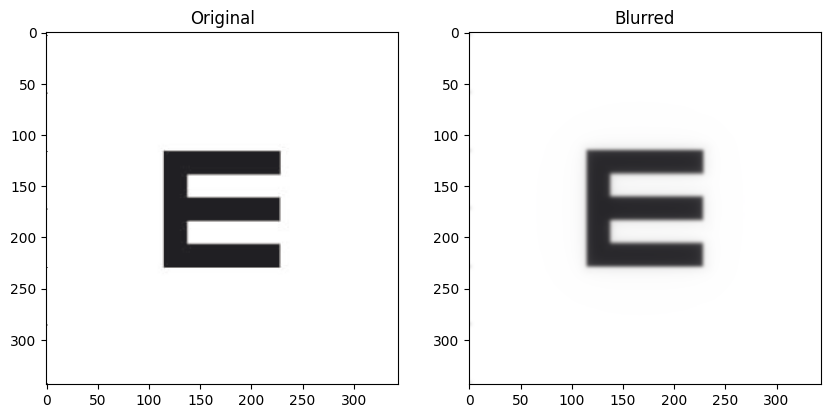

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import Wrap
import math
import cv2
import sys

# 論文第六頁內有提到參數的相關設置
def ZernikePointSpread(coefficients, **kwargs):
    wavelength = kwargs.get("Wavelength", 555)
    pupil = kwargs.get("PupilDiameter", 6)
    otfq = kwargs.get("OTF", False)
    pupilsamples = kwargs.get("PupilSamples", 62.8974)
    imagesamples = kwargs.get("ImageSamples", 256)
    degrees = kwargs.get("Degrees", 0.5)
    apod = kwargs.get("Apodization", False)
    verbose = kwargs.get("Verbose", False)
    
    # print(degrees)
    if "Degrees" not in kwargs.keys():
        degrees = PSFDegrees(pupilsamples, wavelength, pupil)
    else:
        pupilsamples = PupilSamples(degrees, wavelength, pupil)
    

    radius = pupilsamples / 2
    ppd = imagesamples / degrees
    # print(isinstance(apod,(int)))
    # pai 有問題(6/15 看了感覺應該沒問題)
    print("type(apod) =",type(apod))
    if type(apod)==int or type(apod)==float:
        pai = PupilApertureImage(radius, apod * radius / (pupil/2))
    else:
        pai = PupilApertureImage2(radius)
    
    # print("coefficient=",coefficients)
    # print("radius=",radius)
    wai = WaveAberrationImage(coefficients, radius)
    # print("wai=",wai)
    # print("pai =",pai)
    gp = pai * np.exp((1j * 2 * np.pi * 10**3 / wavelength) * wai)
    print("gp=",type(gp))
    w=np.size(gp,0)
    
    print("gp_shape =",w)
    print("(0, imagesamples - gp.shape[0]) =",(0, imagesamples - gp.shape[0]))
    np.set_printoptions(threshold=70)
    # print("NumPy set_printoptions(threshold=20)\n", np.arange(20))
    print("gp =",np.array(gp))
    print(gp.shape)
    # 這裡會報錯(ok!)
    if imagesamples > pupilsamples:
        pgp = np.pad(gp, (imagesamples-w,0), mode='constant',constant_values=0)
    else:
        pgp = gp
    # mathematica 的輸出
    # img = 256
    # img {1, 1}
    # {256, 256}
    # 從這裡開始看
    psf = np.abs(np.fft.ifftshift(np.fft.ifft2(pgp)))**2
    psf /= np.sum(psf)
    
    otf = imagesamples * np.fft.ifftshift(np.fft.ifft2(psf)) if otfq == True or otfq == "Both" else []
    
    if verbose:
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.imshow(pai, extent=(-pupil/2, pupil/2, -pupil/2, pupil/2))
        plt.title("Pupil aperture")
        
        plt.subplot(2, 2, 2)
        plt.imshow(wai, extent=(-1, 1, -1, 1))
        plt.title("Wave aberration")
        
        plt.subplot(2, 2, 3)
        plt.imshow(np.real(pgp), extent=(-pupil/2, pupil/2, -pupil/2, pupil/2))
        plt.title("Generalized pupil")
        
        plt.subplot(2, 2, 4)
        plt.imshow(psf, extent=(-degrees/2, degrees/2, -degrees/2, degrees/2))
        plt.title("PSF")
        
        plt.show()
        
        # print("Scale = ", 2 * radius / pupil, " pixels/mm.")
        # print("Pupil samples = ", pupilsamples)
        # print("PSF image dimensions = ", pgp.shape)
        # print("Equivalent Defocus ", EquivalentDefocus(coefficients, pupil), " diopters")
        # print("PSF image size = ", degrees, " degrees")
        # print("PSF image resolution = ", ppd, " pixels/deg")
        # print("PSF image nyquist = ", ppd / 2, " pixels/deg")
        # print("OTF image resolution = ", 1 / degrees, " cycles/deg/pixel")
        # print("OTF image nyquist = ", imagesamples / degrees / 2, " cycles/deg")

    return otf if otfq == True else psf if otfq == False else [psf, otf]
def PupilSamples(degrees, wavelength, pupildiameter):
    # 在 mathematica 中的 Degree 的功能即為 角度轉弧度(np.deg2rad)
    return np.deg2rad(10**6 * degrees * pupildiameter) / wavelength

def WaveAberrationImage(coefficients, radius=16):
    # print("radius = ",radius)
    # 先看 ZernikeImage
    print("Total =",np.sum([coef[2] * ZernikeImage(coef[0], coef[1], radius) for coef in coefficients]))
    return np.sum([coef[2] * ZernikeImage(coef[0], coef[1], radius) for coef in coefficients])

def PSFDegrees(pupilsamples, wavelength, pupildiameter):
    return pupilsamples * wavelength * 180 * (10**(-6)) / (pupildiameter * np.pi)

def PupilApertureImage2(radius):
    h = int(np.ceil(radius))
    # print("h =",h)
    # print("Table =", np.array([[0 if abs(x + 1j*y) > radius else 1 for x in range(-h, h)] for y in range(-h, h)]))
    # 1j 用來表示虛數的 i
    return np.array([[0 if abs(x + 1j*y) > radius else 1 for x in range(-h, h)] for y in range(-h, h)])

def PupilApertureImage(radius, sd):
    h = int(np.ceil(radius))
    # 1j 用來表示虛數的 i
    return np.array([[0 if abs(x + 1j*y) > radius else np.exp(-0.5 * ((abs(x + 1j*y) / sd)**2)) for x in range(-h, h)] for y in range(-h, h)])

def EquivalentDefocus(coefficient, pupildiameter):
    return (16 * np.sqrt(3) * pupildiameter**-2) * coefficient

def ZernikeImage(n, m, radius):
    h = int(np.ceil(radius))
    # print(type(PolarList(radius)))
    R = PolarList(radius)
    r=R[:,0]
    a=R[:,1]
    # print(a)
    r = np.where(r == 0., np.finfo(float).eps, r)
    # print(r)
    aperture_image = ApertureImage(radius)
    # n, m=2.0,-2.0
    zernike=[]
    # print(np.size(r))
    for i in range(np.size(r)):
        zernike.append(Zernike(n, m, r[i], a[i]))
    packed_array = np.array(zernike).reshape((2 * h, 2 * h))
    return packed_array

def PolarList(radius):
    h = int(np.ceil(radius))
    cartesian_points = []
    for i in range(-h, h):
        for j in range(-h, h):
            x = i / radius
            y = j / radius
            r, a = CartesianToPolar((x, y))
            cartesian_points.append([r, a])
    packed_array = np.array(cartesian_points)
    # print(packed_array)
    return packed_array

def Zernike(n, m, r, a):
    # 這裡的計算感覺是以 r a 是一個值的計算，但他們是兩個陣列，所以要改一下計算方式，回傳一陣列
    zernike_value = np.where(r > 1, 0, np.where(m < 0, -1, 1) * NZ(n, m) * RZ(n, m, r) * AZ(n, m, a))
    return zernike_value
    
def ApertureImage(radius):
    h = int(np.ceil(radius))
    image = np.zeros((2 * h, 2 * h))
    for i in range(-h, h):
        for j in range(-h, h):
            if np.linalg.norm([i, j]) > radius:
                image[i + h, j + h] = 0
            else:
                image[i + h, j + h] = 1
    return image

def CartesianToPolar(point):
    x, y = point
    r = np.linalg.norm([x, y])
    a = np.arctan2(y, x)
    return r, a

def RZ(n, m, r):
    # py 遞迴預設數量為 1000 左右，這裡遞迴會太深
    # 所以在這裡改了遞迴的深度
    sys.setrecursionlimit(1000000000)
    if m<0:
        m=-m
    s_values = np.arange(0, (n - m) // 2 + 1)
    # print(r)
    
    
    result=[]
    for s in s_values:            
        result.append(np.where(r>1,0, 
                        np.where((n-m)%2!=0, 0, 
                        np.where(m==0 and r==0, (-1)**(n/2), 
                        calculate_RZ(n, m, s, r)))))
    return np.sum(result)

def calculate_RZ(n, m, s, r):
    # print(n - m)
    # 因為計算太長，加一個自己加的 function
    result = (-1) ** s * np.math.factorial(int(n - s)) * r ** (n - 2 * s) / (
        np.math.factorial(int(s)) * np.math.factorial(int((n + m) // 2 - s)) * 
        np.math.factorial(int((n - m) // 2 - s))
    )

    return result

def AZ(n, m, a):
    if m < 0:
        return math.sin(m * a)
    else:
        return math.cos(m * a)
    
def NZ(n, m):
    if m == 0:
        return math.sqrt(2 * (n + 1)/2)
    else:
        return math.sqrt(2 * (n + 1))

zc=np.array([[2,-2,-0.0946],[2,0,0.0969],[2,2,0.305],[3,-3,0.0459],[3,-1,-0.121],
    [3,1,0.0264],[3,3,-0.113],[4,-4,0.0292],[4,-2,0.03],[4,0,0.0294],
    [4,2,0.0163],[4,4,0.064]])
psf=ZernikePointSpread(zc)
# print(psf)
letter=cv2.imread("C:\\Users\\user\\Project\\PSF\\letter.png")
blurredImg=cv2.filter2D(src=letter,ddepth=-1,kernel=Wrap.wrap(psf))
# cv2.imshow('Blurred Img',blurredImg)
# cv2.waitKey(0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(letter, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Blurred")
plt.imshow(blurredImg, cmap='gray')
plt.show()